In [33]:
import sys
sys.path.append("../")

import torch
import numpy as np
from sklearn.manifold import TSNE

from train import ModelTester
from const import tsne_cluster
from data import Tokenizer
from utils import embedding, load_transformer_model

In [34]:
show_progress_bar = False
is_augment = True
model_backbone = "transformer"
loss_type = "SupConWithTanimotoLoss"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
tokenizer = Tokenizer(100, show_progress_bar)
model = load_transformer_model(device, loss_type, is_augment)
tester = ModelTester(model, device, show_progress_bar)

In [35]:
from collections import defaultdict

def get_smiles_compound_name(spectra):
    smiles2spectra = defaultdict(list)
    for s in spectra:
        smiles = s.get("smiles")
        smiles2spectra[smiles].append(s)
    smiles2spectra = dict(smiles2spectra)

    smiles_seq = []
    lengths = []
    compund_names = []

    for k, v in smiles2spectra.items():
        smiles_seq.append(k)
        lengths.append(len(v))
        compund_names.append(v[0].get("compound_name"))
    
    smiles_seq = np.array(smiles_seq)
    lengths = np.array(lengths)
    compund_names = np.array(compund_names)
    indices = np.argsort(lengths)[::-1][:10]
    tsne_spectra = []
    labels = []
    for smiles, length, compound_name in zip(smiles_seq[indices], lengths[indices], compund_names[indices]):
        tsne_spectra.extend(smiles2spectra[smiles])
        if len(compound_name) > 30:
            compound_name = "Veratric acid"
        labels.extend([compound_name] * length)
    return np.array(tsne_spectra), np.array(labels)

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

sns.set_style("whitegrid")
sns.set_palette("tab10")

fm.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/times.ttf')
plt.rcParams['font.family'] = 'Times New Roman'

def tsne_plot(data, labels):
    figure, ax = plt.subplots(1, 1, dpi=300, figsize=(6, 3))
    sns.scatterplot(
        x=data[:, 0], 
        y=data[:, 1], 
        hue=labels, 
        ax=ax, 
        edgecolor='none', 
        s=10,
        alpha=0.7
    )
    # ax.legend().remove()
    ax.legend(bbox_to_anchor=(1.02, 0.5), ncol=1, loc="center left", frameon=False)
    figure.tight_layout()
    return figure

In [37]:
spectra = np.load(tsne_cluster.SPECEMBEDDING_TSNE, allow_pickle=True)
spectra, labels = get_smiles_compound_name(spectra)

spectra_embedding, _ = embedding(
    tester, tokenizer,
    512, spectra,
    False
)
tsne = TSNE()
data = tsne.fit_transform(spectra_embedding)

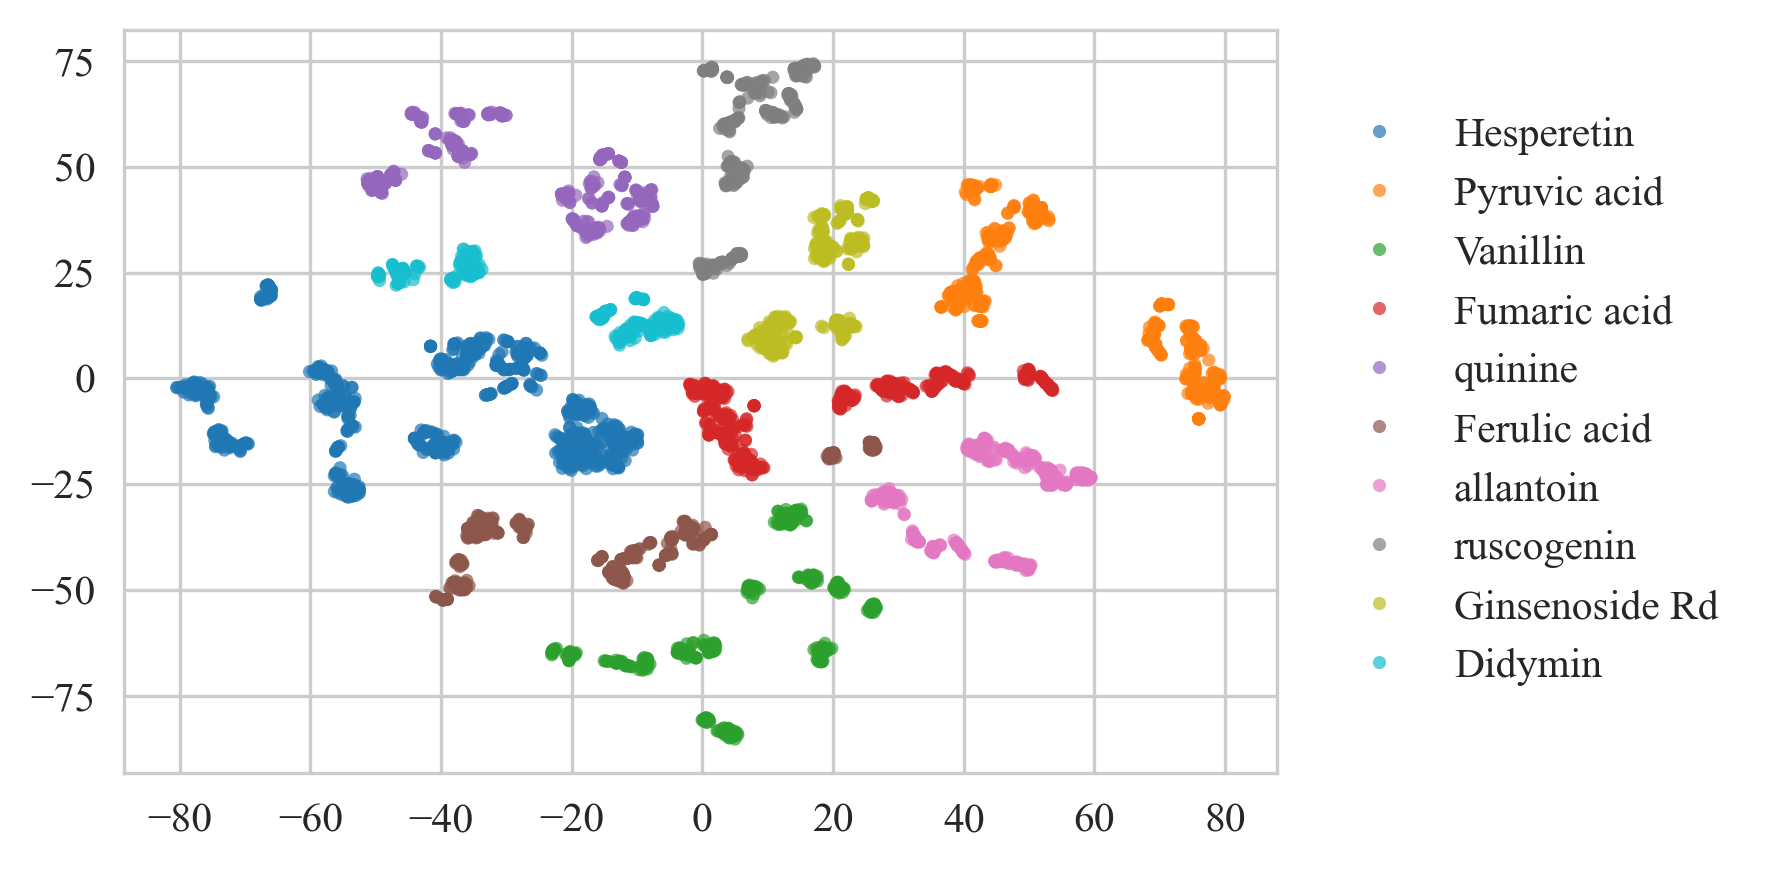

In [38]:
f_sm = tsne_plot(data, labels)

f_sm.savefig("./figures/tsne_sm.png", transparent=True, bbox_inches="tight")
f_sm.savefig("./figures/tsne_sm.svg", transparent=True, bbox_inches="tight")
f_sm.savefig("./figures/tsne_sm.pdf", transparent=True, bbox_inches="tight")

In [39]:
spectra = np.load(tsne_cluster.MSBERT_TSNE, allow_pickle=True)
spectra, labels = get_smiles_compound_name(spectra)

spectra_embedding, _ = embedding(
    tester, tokenizer,
    512, spectra,
    False
)
tsne = TSNE()
data = tsne.fit_transform(spectra_embedding)

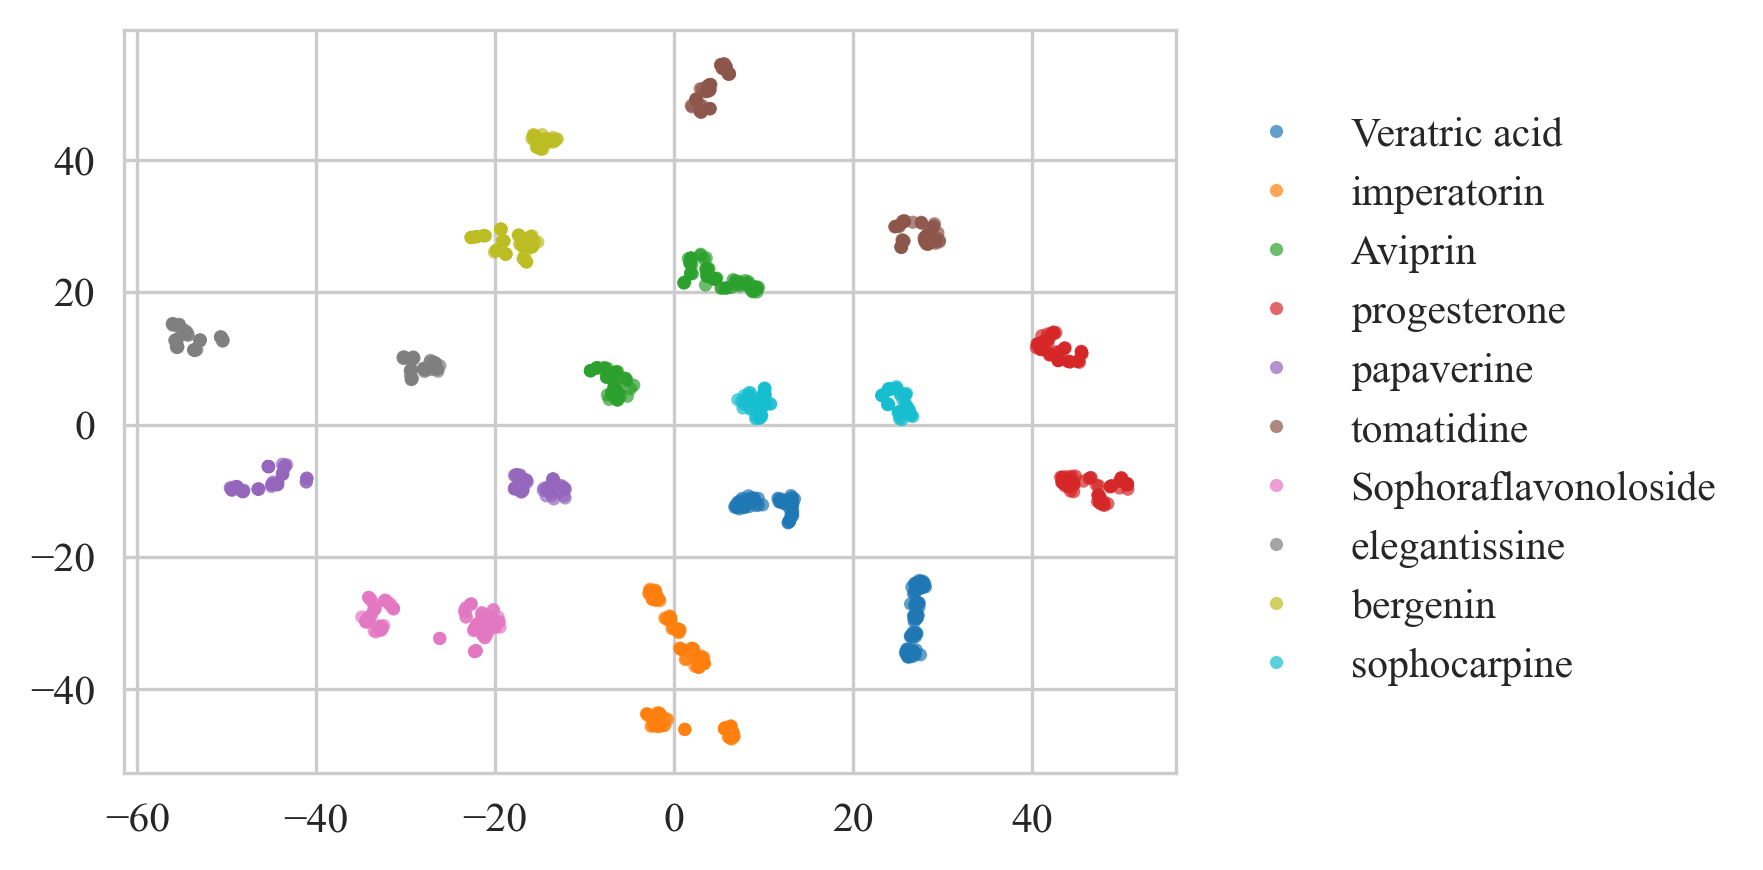

In [40]:
f_mb = tsne_plot(data, labels)

f_mb.savefig("./figures/tsne_mb.svg", transparent=True, bbox_inches="tight")
f_mb.savefig("./figures/tsne_mb.png", transparent=True, bbox_inches="tight")
f_mb.savefig("./figures/tsne_mb.pdf", transparent=True, bbox_inches="tight")